In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd 
import simplejson as json
import pickle
import dill
import sets
import re
import math

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.svm import SVR, SVC 
from sklearn import cross_validation
from sklearn.datasets import load_boston
from sklearn import pipeline
from sklearn.externals import joblib 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_extraction  import DictVectorizer
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV 
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, MinMaxScaler, PolynomialFeatures, normalize 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.cluster import KMeans
from sklearn import datasets

from scipy.optimize import minimize
from scipy.interpolate import SmoothBivariateSpline, RectBivariateSpline

from geopy.distance import vincenty 

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: the sets module is deprecated


In [69]:
"""load public suggestion data"""

# df = pd.read_csv('data/suggestions-features.csv')

# df.sort('weight', ascending=False)
# df = df.drop(507)

# def classify(num):
#     if num < 10:
#         return num
#     elif num < 15:
#         return 10
#     elif num < 20:
#         return 15
#     elif num < 30:
#         return 20
#     elif num < 40:
#         return 30
#     elif num < 50:
#         return 40
#     else:
#         return 50
    
    
# df['classified_weight'] = df['weight'].map(classify)
# y = df.ix[:,'classified_weight'].astype(float)

tuples = df.ix[:,['lat','lng','weight']]
X= []
for tuple_ in tuples.itertuples(index=False):
    for i in range(tuple_[2]+1):
        X.append(tuple_[0:2])
        
X = np.array(X)
print X.shape

#KMeans
est = KMeans(500)
est.fit(X)

centers = est.cluster_centers_
pd.DataFrame(centers).to_csv('data/kmeans_weighted_500.csv', index=False)
# plt.xlim = [-125,-120]
# plt.scatter(centers[:,1], centers[:,0])

# Training 
build a regression model using location features of current stations, to predict the bike usage

In [3]:
with open('data/station_counts.csv', 'r') as f:
    stations = pd.read_csv(f)
    
stations['if train'] = stations['train'] > 0
stations['trips_per_dock'] = 1.0 * stations['total counts'] / stations['dockcount']

In [4]:
# data preprcessing
keywords = ['elevation', 'if train', 'bus', 'food', 'shopping', 'park', 'school']
X = stations[keywords].astype(float)
y = stations['trips_per_dock']  # trips per dock
# y = np.log10(y)

# add many X=0, y=0 data
nzero = 20
zeroX = pd.DataFrame(np.zeros((nzero, len(keywords))), columns=keywords)
zeroy = pd.Series(np.zeros(nzero))
X = X.append(zeroX, ignore_index=True)
y = y.append(zeroy)

In [18]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2)

pipe = pipeline.Pipeline([
        ('normalize', MinMaxScaler()),
#         ('polynomials', PolynomialFeatures(2)),
#         ('estimator', LassoCV()),
        ('estimator', RandomForestRegressor()),
    ])

pipe.fit(X_train,y_train)
print pipe.score(X_test,y_test)
est = pipe.named_steps['estimator']
# print pipe.named_steps['estimator'].coef_
coefs = pipe.named_steps['estimator'].feature_importances_
# y_pred = pipe.predict(X_test)
# print np.array(y_test[-6:])#.astype(int)
# print y_pred[-6:]#.astype(int)
# print keywords

0.534095669815


<Container object of 7 artists>

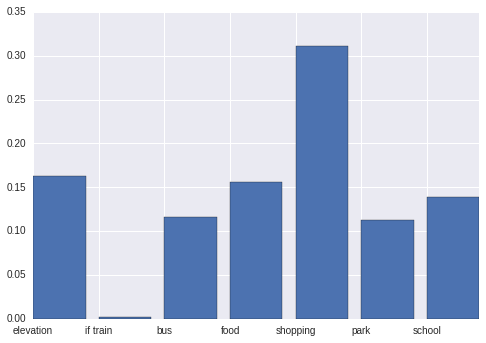

In [19]:
# feature importance

x1 = [1,2,3,4,5,6,7]
plt.xticks(x1, keywords)
plt.bar(x1, abs(coefs))

# prediction
1. prediction on public suggested locations

In [23]:
# prediction on suggested locations
# keywords = ['elevation', 'if train', 'bus', 'food', 'shopping', 'park', 'school']
# X = df.ix[:,keywords].astype(float)
# trans = MinMaxScaler()
# X = trans.fit_transform(X)

# counts_pred = pipe.predict(X)
# counts_pred = 10**counts_pred
# counts_pred = counts_pred.astype(int)

df['predicted_trips_per_dock'] = counts_pred
# df.to_csv('data/suggestions_pred.csv',index=False)

In [25]:
# Francesco note: 1D cut

# stations.plot(x='bus', y='total counts', kind='scatter', logy=True)
# xg = np.arange(-10, 80, 1)
# XG = pd.DataFrame([xg, mean....])
# yg = pipe.predict(XG)
# plot(xg, yg)

In [27]:
# stations[stations['if train'] == 1].hist('trips_per_dock', bins=10, alpha=0.5)
# plt.legend(['has train station in 300m'])
# stations[stations['if train'] == 0].hist('trips_per_dock', bins=10, alpha=0.5)
# plt.legend(['no train station in 300m'])

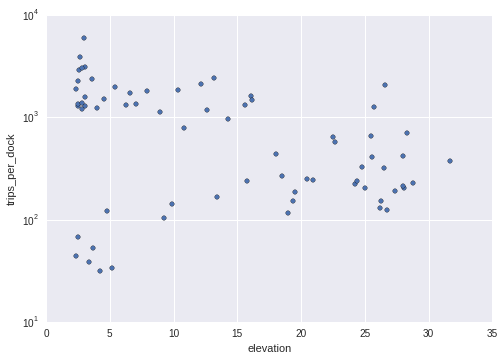

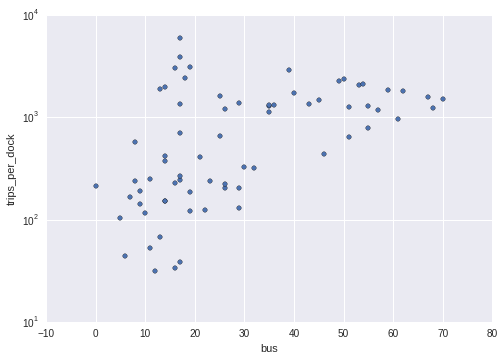

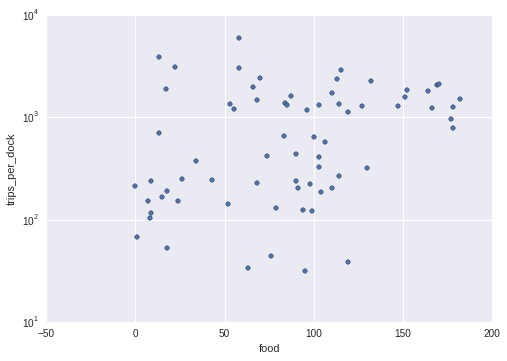

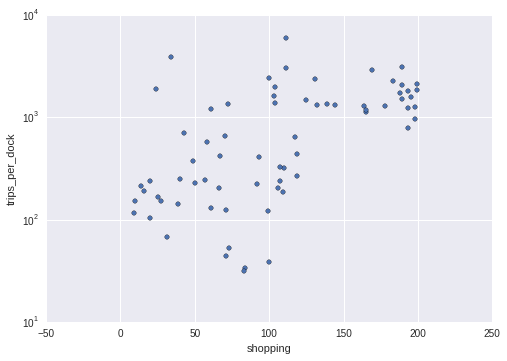

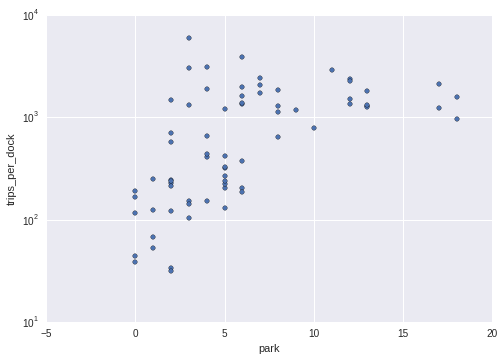

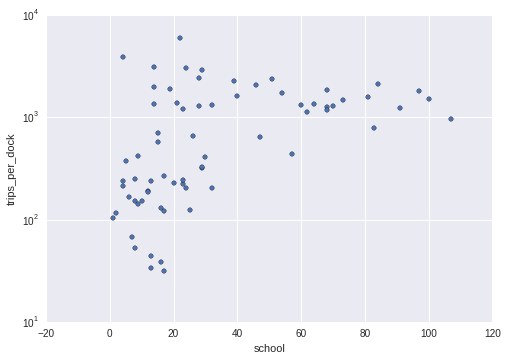

In [28]:
keywords = ['elevation',  'bus', 'food', 'shopping', 'park', 'school']
# keywords = ['elevation','school']
for keyword in keywords:
    stations.plot(x=keyword, y='trips_per_dock', kind='scatter', logy=True)

2. prediction on grid points

In [29]:
# predict on the grid
with open('data/grid.csv', 'r') as f:
    grid = pd.read_csv(f)

grid['if train'] = grid['train'] > 0
keywords = ['elevation', 'if train', 'bus', 'food', 'shopping', 'park', 'school']
X = grid[keywords]

y_pred = pipe.predict(X)
grid['predicted'] = y_pred.astype(int)
grid['predicted_log'] = np.log1p(grid['predicted'])

# grid['predicted'].hist()

In [31]:
# create a Gaussian perturbed sample for map visualization on CartoDB

dup = np.abs(grid['predicted'] / 30)
dup = dup.astype(int)
grid['copy'] = dup
cols = ['lat', 'lng', 'copy']
grid_pred = grid[cols]

n = test['copy'].astype(int)
jitter = np.random.normal(scale=0.0005, size=(n,3))
grid_pred = grid_pred.append([test]*10, ignore_index=True )
np.array([test]*n) + jitter

for i in range(grid.shape[0]):
    row = grid_pred.ix[i,:]
    n = row['copy'].astype(int)
    if n >0:
        jitter = np.random.normal(scale=0.001, size=(n,3))
        copies = np.array([row]*n) + jitter
        grid_pred = grid_pred.append(pd.DataFrame(copies, columns=cols), ignore_index=True)
        
grid_pred.to_csv('data/grid_pred_copy.csv', index=False)

In [34]:
# grid
def GenGrid(lowerleft, upperright, npt):
    lat = np.linspace(lowerleft[0], upperright[0], npt)
    lng = np.linspace(lowerleft[1], upperright[1], npt)
    latv, lngv = np.meshgrid(lat, lng)
    locs = zip(latv.reshape(npt**2), lngv.reshape(npt**2))
    return locs

lowerleft = (37.71626, -122.513951)
upperright = (37.811164, -122.385373)
locs = GenGrid(lowerleft,upperright,35)

# locs = np.array(locs)

xg = [loc[0] for loc in locs]
yg = [loc[1] for loc in locs]

In [237]:
grid['predicted'].describe()

count    1225.000000
mean      619.869388
std       621.032578
min         0.000000
25%       224.000000
50%       343.000000
75%       890.000000
max      3141.000000
Name: predicted, dtype: float64

In [ ]:
# optimization and recommendation

In [11]:
with open('data/grid_pred.csv', 'r') as f:
    grid = pd.read_csv(f)


In [12]:
def GenLinspace(lowerleft, upperright, npt):
    lat = np.linspace(lowerleft[0], upperright[0], npt)
    lng = np.linspace(lowerleft[1], upperright[1], npt)
    return lat, lng

lowerleft = (37.71626, -122.513951)
upperright = (37.811164, -122.385373)
lat, lng = GenLinspace(lowerleft,upperright,35)


xg = np.array(lat)
yg = np.array(lng)
zg = grid['predicted'].reshape(35,35).T
sp = RectBivariateSpline(xg, yg, zg, kx=2, ky=2, s=0)
print sp.get_residual()

0.0


In [399]:
print zg.T[:,-1]
print xg[15]
print yg[-1]
sp(37.777668, -122.386413)

[   0    0    0    0    0    0    0    0    0    0   17   17   17    0    0
    0    0    0    0    0    0   23   23   23  327   78 2266  309   38   23
   17    0    0    0    0]
37.7581294118
-122.385373


array([[ 226.93758504]])

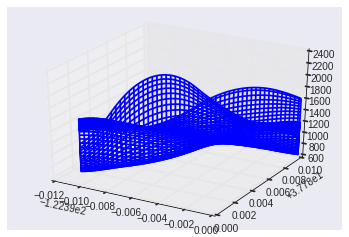

In [262]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# fig = plt.figure()
# ax = fig.gca(projection='3d')

# lat, lng = GenLinspace(lowerleft,upperright,35)
# latv, lngv = np.meshgrid(lat, lng)

# surf = ax.plot_surface(latv, lngv, zg, rstride=1, cstride=1, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)


fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')

xtest = np.linspace(-122.40, -122.39, 100)
ytest = np.linspace(37.78, 37.79, 100)
ztest = sp(ytest,xtest)

# surf2 = ax2.plot_surface(xtest, ytest, ztest, rstride=1, cstride=1, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
ax2.plot_wireframe(xtest, ytest, ztest, rstride=2, cstride=2)

# ax.set_xlim(37.76, 37.82)
# ax.set_ylim(-122.465373, -122.385373)

# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


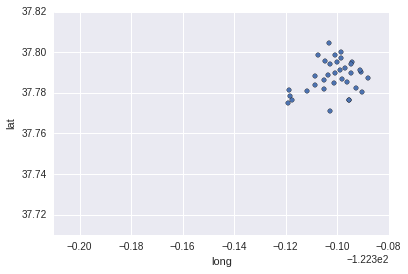

In [274]:
stations.plot('long','lat',kind='scatter',
              xlim=[-122.51, -122.38], ylim=[37.71, 37.82])

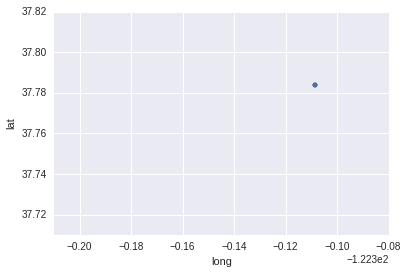

In [295]:
stations.groupby('landmark').get_group('San Francisco').iloc[0:1,].plot(
    'long','lat',kind='scatter', 
    xlim=[-122.51, -122.38], ylim=[37.71, 37.82])

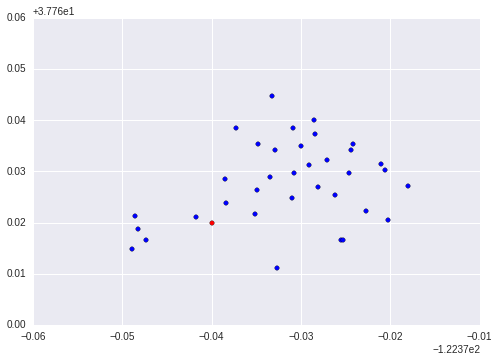

In [13]:
stations_sf = stations.groupby('landmark').get_group('San Francisco')

x = stations_sf['long']
y = stations_sf['lat']
plt.scatter(x, y)
x1 = -122.41
y1 = 37.78
plt.scatter(x1, y1, c='r')


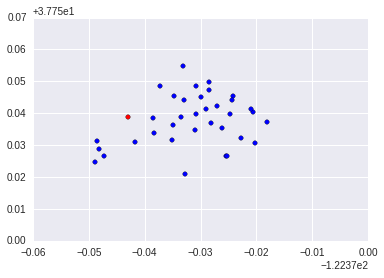

In [411]:
stations_sf = stations.groupby('landmark').get_group('San Francisco')

x = stations_sf['long']
y = stations_sf['lat']
plt.scatter(x, y)
newloc = (37.78891955, -122.4130005 )
y1 = newloc[0]
x1 = newloc[1]
plt.scatter(x1, y1, c='r')


In [ ]:
def cost1(x):
    return (x-100)**2 -146*x + 0.2*x**3

x0 = 10
res = minimize(cost(,locs), x0, method='nelder-mead', 
               options={'xtol': 1e-8, 'disp': True})

In [91]:
math.exp( -sp(newlocs[0][0], newlocs[0][1])[0][0])

0.0

In [111]:
def cost(newloc):
    r = MinDist(newloc)
    # Morse potential for distance cost 
    cost_dist = 1 * (1 - math.exp(-2.0*(r-0.35)))**2
    
    """
    exponential decay for usage cost, use median usage 
    of current stations as para
    """
    usage = abs(sp(newloc[0], newloc[1])[0][0])
#     cost_usage = (1. / usage + 1))[0][0]
    cost_usage = math.exp(- usage / 300.0)
    return cost_dist + cost_usage

def MinDist(newloc):
    dists = [vincenty(newloc, loc).km for loc in locs]
    return min(dists)



  status: 0
 success: True
   direc: array([[ 1.,  0.],
       [ 0.,  1.]])
    nfev: 60
     fun: 1.0004405875998104
       x: array([  42.9645721 , -122.41552066])
 message: 'Optimization terminated successfully.'
     nit: 2


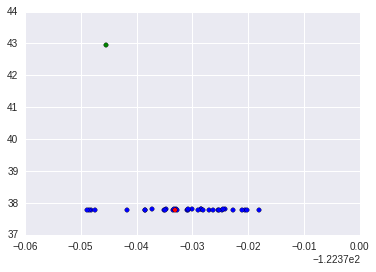

In [657]:
# newloc = (37.78, -122.41)
x = np.random.uniform(37.75, 37.81)
y = np.random.uniform(-122.47, -122.39)
newloc = (x, y)
res = minimize(cost, newloc, method='Powell',)
#                options={'xtol': 1e-8, 'disp': True})
print res

stations_sf = stations.groupby('landmark').get_group('San Francisco')
x = stations_sf['long']
y = stations_sf['lat']
plt.scatter(x, y)

# def add1p(loc,color):
y1 = newloc[0]
x1 = newloc[1]
plt.scatter(x1, y1, c='r')
    
y1 = res['x'][0]
x1 = res['x'][1]
plt.scatter(x1, y1, c='g')


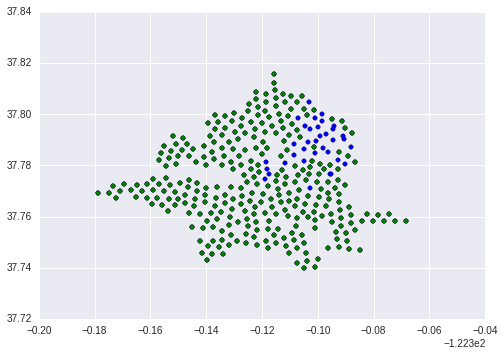

In [116]:
N = 300
m = 3
def genStation(locs, m):
    candidates = []
    for i in range(m):
        x = np.random.uniform(37.75, 37.81)
        y = np.random.uniform(-122.47, -122.39)
        newloc = (x, y)
        res = minimize(cost, newloc, method='Powell')
        if abs(res['fun']) < 0.1:
            candidates.append( (res['x'], res['fun']) )
    if len(candidates) > 0:
        candidate = min(candidates, key=lambda x: x[1])
        return candidate
    else:
        pass

def PlotScatter(locs, newlocs):
    x = [loc[1] for loc in locs]
    y = [loc[0] for loc in locs]
    plt.scatter(x, y, c='b')

    x = [loc[1] for loc in newlocs]
    y = [loc[0] for loc in newlocs]
    plt.scatter(x, y, c='g')

    
locs = [loc for loc in stations_sf[['lat','long']].itertuples(index=False)]
newlocs = []
newvalues = []
for i in range(N):
    try:
        loc, cost_value = genStation(locs, m)
        newlocs.append(loc)
        newvalues.append(cost_value)
        locs.append(loc)
#         print i
    except TypeError:
        print 'error'

exp_usage = newlocs
exp_usage_values = newvalues

PlotScatter(locs, newlocs)

In [71]:
inverse_usage = newlocs

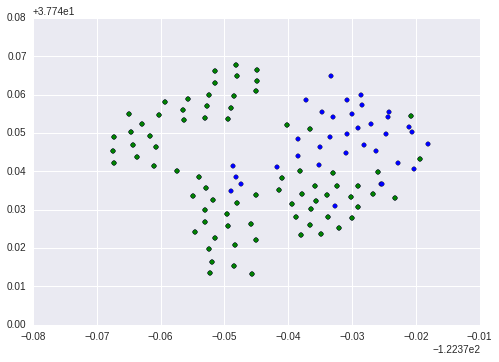

In [107]:
# new300_400m = newlocs
# new300_300m
PlotScatter(locs, newlocs)
# newvalues

In [38]:
stations_new = pd.DataFrame(newlocs, columns=['lat','lng'])
stations_new.to_csv('data/station_new.csv', index=False)

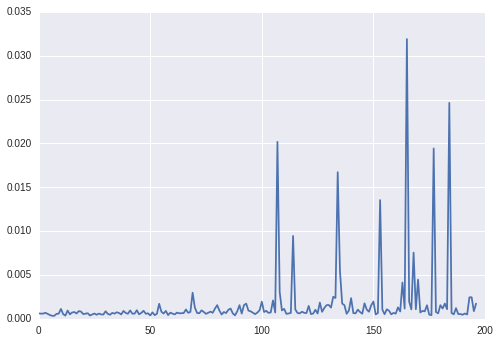

In [35]:
plt.plot(newvalues)

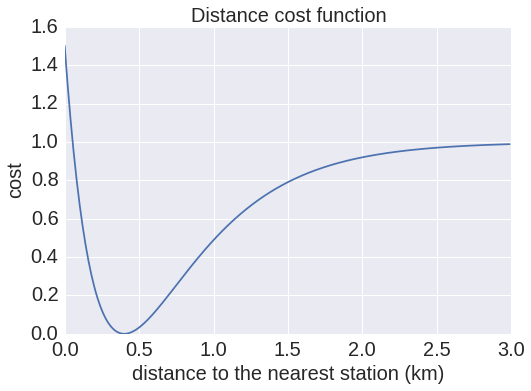

In [60]:
# plot distance cost function
x = np.arange(0, 3, 0.01);
y = 1*(1-np.exp(-2*(x-0.4)))**2

f, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Distance cost function', fontsize=20)

xtics = np.linspace(0,3,7)
ytics = np.linspace(0,1.6,9)
ax.set_xlabel('distance to the nearest station (km)', fontsize=20)
ax.set_xticklabels(xtics, fontsize=20)
ax.set_ylabel('cost', fontsize=20)
ax.set_yticklabels(ytics, fontsize=20)

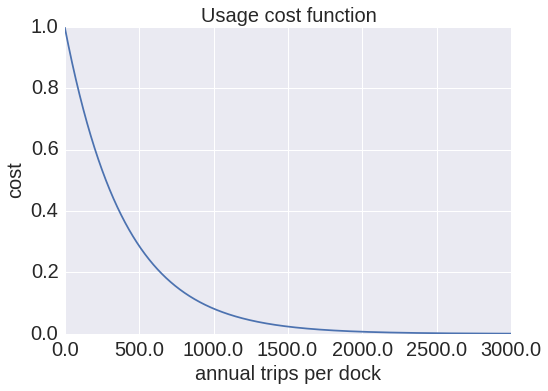

In [117]:
# plot usage cost function
x = np.arange(0, 3000, 0.01);
# y = 1.0 / (0.01*x+1)
y = np.exp(-x/400)

f, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Usage cost function', fontsize=20)

ax.set_xlim(0, 3000)

xtics = np.linspace(0,3000,7)
ytics = np.linspace(0,1.0,6)
ax.set_xlabel('annual trips per dock', fontsize=20)
ax.set_xticklabels(xtics, fontsize=20)
ax.set_ylabel('cost', fontsize=20)
ax.set_yticklabels(ytics, fontsize=20)

In [115]:
stations_sf['trips_per_dock'].describe()

count      35.000000
mean     1814.785920
std      1020.576554
min       433.684211
25%      1272.656140
50%      1490.466667
75%      2092.789474
max      5909.000000
Name: trips_per_dock, dtype: float64